# Data Science Take Home Challenge - Relax

This notebook is the Take Home Data Science Challenge for Relax Inc. as part of exercise for Springboard Data Science Career Intensive Program.

#### Data:

1. takehome_user_engagement.csv: has a row for each day that a user logged into the product 
2. takehome_users.csv : data on 12,000 users who signed up for the product in the last two years

#### Objective:

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.


### Imports

In [231]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autoreload 2

# Load general utilities
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy


# Load sklearn utilities
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, \
roc_auc_score, roc_curve, precision_recall_curve, auc, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

In [7]:
!ls

Take_Home_Challenge_2.ipynb      takehome_user_engagement.csv
relax_data_science_challenge.pdf takehome_users.csv


In [12]:
df_user = pd.read_csv('takehome_users.csv', encoding = 'latin1')#'ISO-8859-1')

df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [92]:
df_eng = pd.read_csv('takehome_user_engagement.csv', 
                     parse_dates=[0], index_col=[0])

In [115]:
df_eng = df_eng.sort_index()
df_eng.head()

,user_id,visited
time_stamp,,
2012-05-31 08:20:06,10012,1
2012-05-31 15:47:36,3428,1
2012-05-31 17:19:37,9899,1
2012-05-31 21:58:33,1693,1
2012-06-01 00:17:30,6102,1


In [116]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2012-05-31 08:20:06 to 2014-06-06 14:58:50
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


### Data Manipulation

In [95]:
# check missing value
df_eng.isnull().sum()

user_id    0
visited    0
dtype: int64

In [96]:
# check the unique value of user_id
df_eng['user_id'].nunique()

8823

There are 8823 unique user_id out of 207917 data entries.

In [97]:
# check visited column
df_eng['visited'].describe()

count    207917.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: visited, dtype: float64

In [112]:
df_eng.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


All the rows in the 'visited' column contains 1.

### Define the labels: 'adopted'

Adopted user : A user logs into the product on three separate days in at least one seven day period. 


- Group by 'user_id'
- Take seven days interval
- label adopted user if the 'visited' is greater or equal to 3.


In [118]:
df_eng_1 = df_eng.groupby(['user_id']).rolling(window='7d')['visited'].sum()

user_id  time_stamp         
1        2014-04-22 03:53:30    1.0
2        2013-11-15 03:45:04    1.0
         2013-11-29 03:45:04    1.0
         2013-12-09 03:45:04    1.0
         2013-12-25 03:45:04    1.0
Name: visited, dtype: float64

In [122]:
df_eng_gb = pd.DataFrame(df_eng_1)
df_eng_gb.head()

visited
user_id time_stamp                  
1       2014-04-22 03:53:30      1.0
2       2013-11-15 03:45:04      1.0
        2013-11-29 03:45:04      1.0
        2013-12-09 03:45:04      1.0
        2013-12-25 03:45:04      1.0

In [123]:
# creat a label
df_eng_gb['adopted'] = np.where(df_eng_gb['visited']>=3, 1, 0)

In [124]:
# percentage of adopted user
perc_adopted=df_eng_gb['adopted'].sum()/len(df_eng_gb)
print(f'Percentage of adopted user = {round(perc_adopted,2)}')

Percentage of adopted user = 0.77


In [126]:
df_eng_gb.head(10)

visited  adopted
user_id time_stamp                           
1       2014-04-22 03:53:30      1.0        0
2       2013-11-15 03:45:04      1.0        0
        2013-11-29 03:45:04      1.0        0
        2013-12-09 03:45:04      1.0        0
        2013-12-25 03:45:04      1.0        0
        2013-12-31 03:45:04      2.0        0
        2014-01-08 03:45:04      1.0        0
        2014-02-03 03:45:04      1.0        0
        2014-02-08 03:45:04      2.0        0
        2014-02-09 03:45:04      3.0        1

In [129]:
df_eng_gb.index = df_eng_gb.index.get_level_values(0)

In [148]:
# iterate over rows with iterrows()
users = dict()
for index, row in df_eng_gb.iterrows():
    if row['adopted'] == 1:
        users[index]=1
    else:
        users[index]=0

In [154]:
type(users.values())

dict_values

In [155]:
df_user_adopted = pd.DataFrame({'user_id': list(users.keys()), 'adopted':list(users.values())})

In [156]:
df_user_adopted.head()

,user_id,adopted
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [157]:
df_user['object_id'].nunique()

12000

#### Merge Dataframes

In [164]:
# merge two dataframes
df_user_m = df_user.merge(df_user_adopted,left_on='object_id', right_on='user_id')

In [165]:
df_user_m.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0


In [185]:
df_user_m.isnull().sum()/len(df_user_m)*100

object_id                      0.000000
creation_time                  0.000000
name                           0.000000
email                          0.000000
creation_source                0.000000
last_session_creation_time     0.000000
opted_in_to_mailing_list       0.000000
enabled_for_marketing_drip     0.000000
org_id                         0.000000
invited_by_user_id            45.868752
user_id                        0.000000
adopted                        0.000000
creation_time_num              0.000000
delta_time                     0.000000
dtype: float64

There are 46% missing value in 'invited_by_user_id'. We can drop this column.

In [168]:
df_user_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   name                        8823 non-null   object 
 3   email                       8823 non-null   object 
 4   creation_source             8823 non-null   object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    8823 non-null   int64  
 7   enabled_for_marketing_drip  8823 non-null   int64  
 8   org_id                      8823 non-null   int64  
 9   invited_by_user_id          4776 non-null   float64
 10  user_id                     8823 non-null   int64  
 11  adopted                     8823 non-null   int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 896.1+ KB


#### Feature Engineering

In [169]:
# work on timestamp columns
df_user_m["creation_time"] = pd.to_datetime(df_user_m['creation_time'] )

In [181]:
# convert to numeric variables
df_user_m["creation_time_num"] = pd.to_numeric(df_user_m["creation_time"])*10**-9

calculate the time difference between last session and create time

In [183]:
# time difference between last session and create time
df_user_m['delta_time'] = df_user_m['last_session_creation_time'] - df_user_m['creation_time_num']

In [184]:
df_user_m.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,creation_time_num,delta_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,1.398139e+09,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,0,1.384487e+09,11750400.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0,1.363735e+09,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0,1.369124e+09,86400.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0,1.358418e+09,432000.0


<AxesSubplot:>

Text(0.5, 1.0, '')

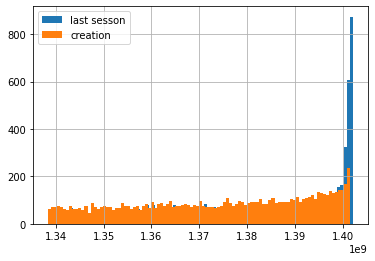

In [196]:
ax = df_user_m['last_session_creation_time'].hist(bins=100, label='last sesson')
df_user_m['creation_time_num'].hist(bins=100, ax=ax, label='creation')
plt.title("")
plt.legend()
plt.show()

In [198]:
df_user_m['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [201]:
df_user_m.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'user_id',
       'adopted', 'creation_time_num', 'delta_time'],
      dtype='object')

In [200]:
df_user_m['name'].nunique()

8453

create listes for categorical and numerical variables

In [203]:
num_list = ['last_session_creation_time','opted_in_to_mailing_list','enabled_for_marketing_drip',
           'creation_time_num', 'delta_time', 'adopted']
cat_list = ['creation_source']

In [207]:
# 
df_ML = df_user_m[num_list+cat_list]
# one hot encoding
df_ML = pd.get_dummies(df_ML, columns=['creation_source'])
df_ML.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_time_num,delta_time,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,1.398139e+09,0.0,0,1,0,0,0,0
1,1.396238e+09,0,0,1.384487e+09,11750400.0,0,0,1,0,0,0
2,1.363735e+09,0,0,1.363735e+09,0.0,0,0,1,0,0,0
3,1.369210e+09,0,0,1.369124e+09,86400.0,0,1,0,0,0,0
4,1.358850e+09,0,0,1.358418e+09,432000.0,0,1,0,0,0,0


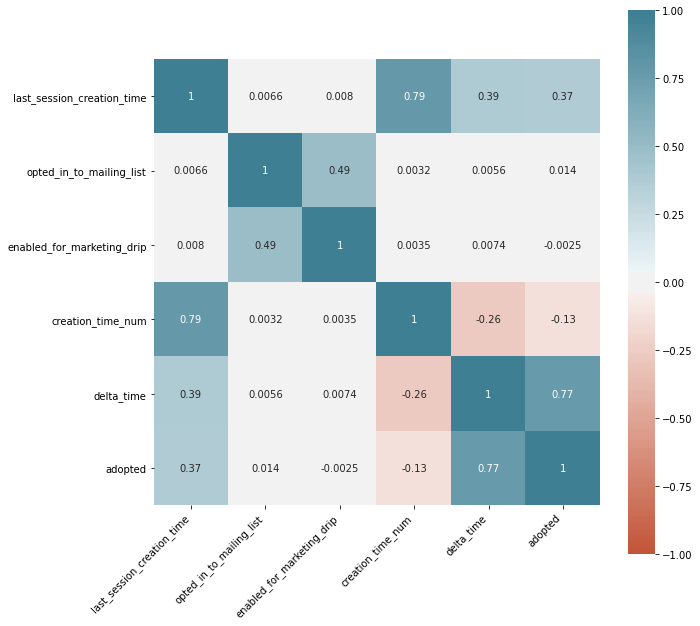

In [210]:
# heatmap

plt.figure(figsize=(10,10))

ax = sns.heatmap(
    df_ML[num_list].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Machine Learning

In [217]:
df_ML.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_time_num,delta_time,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,1.398139e+09,0.0,0,1,0,0,0,0
1,1.396238e+09,0,0,1.384487e+09,11750400.0,0,0,1,0,0,0
2,1.363735e+09,0,0,1.363735e+09,0.0,0,0,1,0,0,0
3,1.369210e+09,0,0,1.369124e+09,86400.0,0,1,0,0,0,0
4,1.358850e+09,0,0,1.358418e+09,432000.0,0,1,0,0,0,0


In [247]:
# set X, y
X=df_ML.drop(['adopted','creation_time_num'], axis=1)
y=df_ML['adopted']

In [248]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [249]:
# Standarization (before resampling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [250]:
# check adopted
df_ML['adopted'].mean()

0.1182137594922362

The target variables are imbalanced. We first need to balance the training data by upsampling

In [251]:
# load imbalanced-learn
from imblearn.over_sampling import SMOTE
import time
start = time.time()
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
end= time.time()
print('It takes  ' + str(round((end-start), 1)) +' sec')

It takes  0.0 sec


In [252]:
# after oversampling
values, counts = np.unique(y_train_res, return_counts=True)
print(values, counts)

[0 1] [6232 6232]


help function to evaluate model

In [253]:
def evaluation_model(model, X_train, y_train, X_test, y_test):
    
    target_names = ['Non-Defaulted Loan','Defaulted Loan']
    y_pred = model.predict(X_test)
    
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred)))
    print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred, \
                                                                            target_names=target_names)))
    print("Accuracy Score: {0:.4f}\n".format(accuracy_score(y_test,  y_pred)))    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    auc_test = cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc')
    print("Stratified KFold Cross Validation:\n")
    print("--Training Set--")
    print("Mean AUC (cv): \t {0:.4f}".format(np.mean(auc_train)))
    print("SD AUC: \t\t {0:.4f}".format(np.std(auc_train)))
    print("--Test Set--")
    print("Mean AUC (cv): \t {0:.4f}".format(np.mean(auc_test)))
    print("SD AUC: \t\t {0:.4f}".format(np.std(auc_test)))

def auc_ruc(X_test, y_test, title, model):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('AUC=', auc)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.plot(fpr, tpr, 'r', lw=2,\
             label='AUC = %0.2f'% auc )
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--', lw=2)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def prc_auc(X_test, y_test, title, model):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    prc_auc = metrics.auc(recall, precision)
    print('PRC-AUC=', auc)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.plot(recall, precision, 'r', lw=2,\
             label='PRC-AUC = %0.2f'% prc_auc )
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--', lw=2)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

from sklearn.model_selection import GridSearchCV
def cv_best_parameters(model, param_grid):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grid,cv=cv, scoring='roc_auc')
    X=X_train_res
    y=y_train_res
    grid.fit(X,y)
    return grid.best_params_, grid.best_score_,grid.best_estimator_

#### Logestic Regression

In [254]:
# hyperparameter tuning
logreg_cv = LogisticRegression(random_state=42)
c=[0.01, 0.1, 1, 10, 100, 200]
param_grid = dict(C=c)
Best_params, Best_AUC, Best_classifier = cv_best_parameters(logreg_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)

Best AUC = 0.963411718998924
LogisticRegression(C=100, random_state=42)


In [255]:
clf_LR = LogisticRegression(C=100, random_state=42)
clf_LR.fit(X_train_res,y_train_res)
evaluation_model(clf_LR, X_train_res, y_train_res, X_test, y_test)

LogisticRegression(C=100, random_state=42)

Confusion Matrix: 
 [[1483   65]
 [  19  198]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.99      0.96      0.97      1548
    Defaulted Loan       0.75      0.91      0.82       217

          accuracy                           0.95      1765
         macro avg       0.87      0.94      0.90      1765
      weighted avg       0.96      0.95      0.95      1765


Accuracy Score: 0.9524

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.9634
SD AUC: 		 0.0032
--Test Set--
Mean AUC (cv): 	 0.9686
SD AUC: 		 0.0146


AUC= 0.9777712285214161


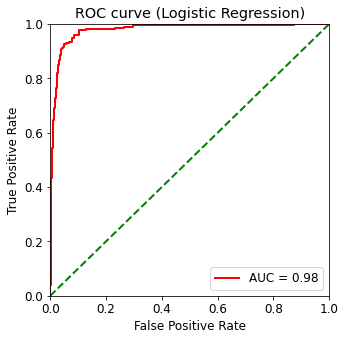

In [256]:
auc_ruc(X_test, y_test, 'ROC curve (Logistic Regression)',clf_LR)

PRC-AUC= <function auc at 0x12afb3670>


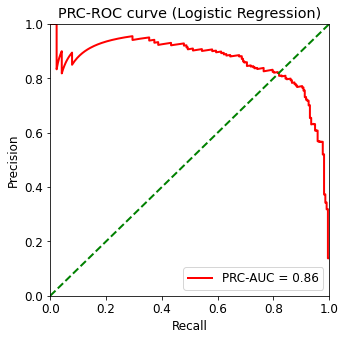

In [257]:
prc_auc(X_test, y_test, 'PRC-ROC curve (Logistic Regression)',clf_LR)

#### Random Forest

In [258]:
RF_cv = RandomForestClassifier(random_state=42)

n_estimators = [20,50,100,200]

param_grid = dict(n_estimators=n_estimators)

Best_params, Best_AUC, Best_classifier = cv_best_parameters(RF_cv,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)

Best AUC = 0.9873841873697028
RandomForestClassifier(n_estimators=200, random_state=42)


In [259]:
clf_RF = RandomForestClassifier(n_estimators=200, random_state=42)
clf_RF.fit(X_train_res,y_train_res)

evaluation_model(clf_RF , X_train_res, y_train_res, X_test, y_test) 

RandomForestClassifier(n_estimators=200, random_state=42)

Confusion Matrix: 
 [[1454   94]
 [  26  191]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.98      0.94      0.96      1548
    Defaulted Loan       0.67      0.88      0.76       217

          accuracy                           0.93      1765
         macro avg       0.83      0.91      0.86      1765
      weighted avg       0.94      0.93      0.94      1765


Accuracy Score: 0.9320

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.9874
SD AUC: 		 0.0024
--Test Set--
Mean AUC (cv): 	 0.9736
SD AUC: 		 0.0145


AUC= 0.972923290346396


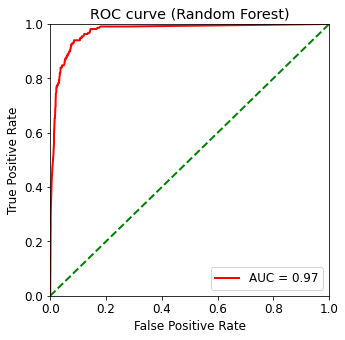

In [260]:
auc_ruc(X_test, y_test, 'ROC curve (Random Forest)', clf_RF)

PRC-AUC= <function auc at 0x12afb3670>


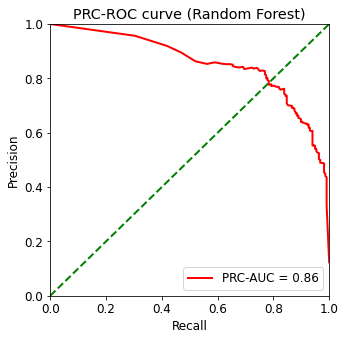

In [261]:
prc_auc(X_test, y_test, 'PRC-ROC curve (Random Forest)',clf_RF)

Feature Importance

<Figure size 576x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Feature Importance (Random Forest)')

Text(0.5, 0, 'Normalized Gini Importance')

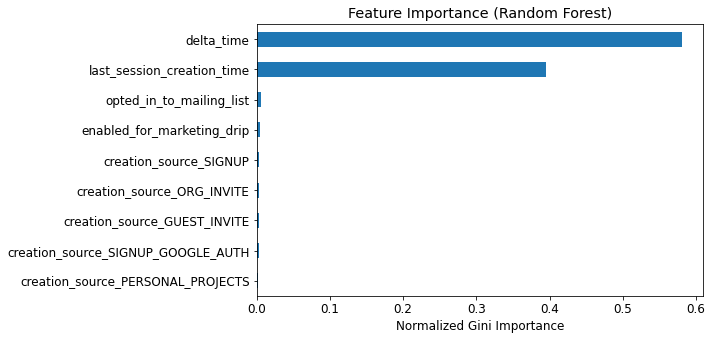

In [262]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,5))
feat_importances = pd.Series(clf_RF.feature_importances_, \
                             index=X.columns)
feat_importances.nlargest(12).sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Normalized Gini Importance')

### Summary

1. The Random Forest Classifier shows the best performance, with AUC=0.97. The feature importance based on Random Forest Model suggest that the user lifetime for the signup (time diffence between last session and creation time) is the most important predictor.

2. It makes sense that the longer user lifetime, the higher the chance they can engage with the product. 

3. The second important feature, 'last_session_creation time', is correlated with delta_time. It shows that when the account was last login also plays a big role in deciding how engaged a user is.

4. The third important feature, 'opt_in_to_mailing_list', reflects the users are willing to receive market email. This is not surprised that the users are more engaged if they are willing to receive market email.

5. Overall, the marketing team can provide more promotion or incentive by email and encourage user to login. The information can leveage to determine future user adoption.